In [52]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import pandas as pd

In [53]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)  # Les caractéristiques commencent à la colonne 1
        # Normalisation
        self.X /= 255
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)     # La première colonne est la cible
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [55]:
training_data = CustomDataset('../../data/sign_mnist_train.csv')
testing_data = CustomDataset('../../data/sign_mnist_test.csv')

train_loader = DataLoader(training_data, batch_size=32, shuffle=True,)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False,)


In [56]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [57]:
model = NeuralNetwork()

In [58]:
# Hyperparamètres
learning_rate = 1e-3
batch_size = 32
epochs = 100

In [61]:
# Initialisation du loss function
loss_fn = nn.CrossEntropyLoss()

# Initialisation de l'optimiseur
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Fonction d'entraînement
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

In [62]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    model.train()
    train_loss, correct = 0.0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(correct)

In [63]:
def test_loop(dataloader, model, loss_fn, history):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct)


In [64]:
for epoch in range(epochs):
    train_loop(train_loader, model, loss_fn, optimizer, history)
    test_loop(test_loader, model, loss_fn, history)

# Save the trained model
torch.save(model.state_dict(), 'model.pt')

loss: 3.251822  [   32/27455]
loss: 3.247879  [ 3232/27455]
loss: 3.254937  [ 6432/27455]
loss: 3.223597  [ 9632/27455]
loss: 3.234306  [12832/27455]
loss: 3.235257  [16032/27455]
loss: 3.227077  [19232/27455]
loss: 3.230920  [22432/27455]
loss: 3.214688  [25632/27455]
Test Error: 
 Accuracy: 7.9%, Avg loss: 3.224364 

loss: 3.227505  [   32/27455]
loss: 3.220117  [ 3232/27455]
loss: 3.206303  [ 6432/27455]
loss: 3.214477  [ 9632/27455]
loss: 3.209640  [12832/27455]
loss: 3.186499  [16032/27455]
loss: 3.184409  [19232/27455]
loss: 3.186874  [22432/27455]
loss: 3.183040  [25632/27455]
Test Error: 
 Accuracy: 4.4%, Avg loss: 3.206047 

loss: 3.208636  [   32/27455]
loss: 3.192710  [ 3232/27455]
loss: 3.204519  [ 6432/27455]
loss: 3.181847  [ 9632/27455]
loss: 3.144174  [12832/27455]
loss: 3.162181  [16032/27455]
loss: 3.156906  [19232/27455]
loss: 3.178942  [22432/27455]
loss: 3.199208  [25632/27455]
Test Error: 
 Accuracy: 3.8%, Avg loss: 3.189728 

loss: 3.151344  [   32/27455]
loss: 3

In [67]:
import matplotlib.pyplot as plt

def plot_performance(history):
    epochs = len(history['train_loss'])

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_acc'], label='Training')
    plt.plot(range(1, epochs+1), history['test_acc'], label='Testing')
    plt.title('Accuracy of the model in training and testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history['train_loss'], label='Training')
    plt.plot(range(1, epochs+1), history['test_loss'], label='Testing')
    plt.title('Loss of the model in training and testing')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

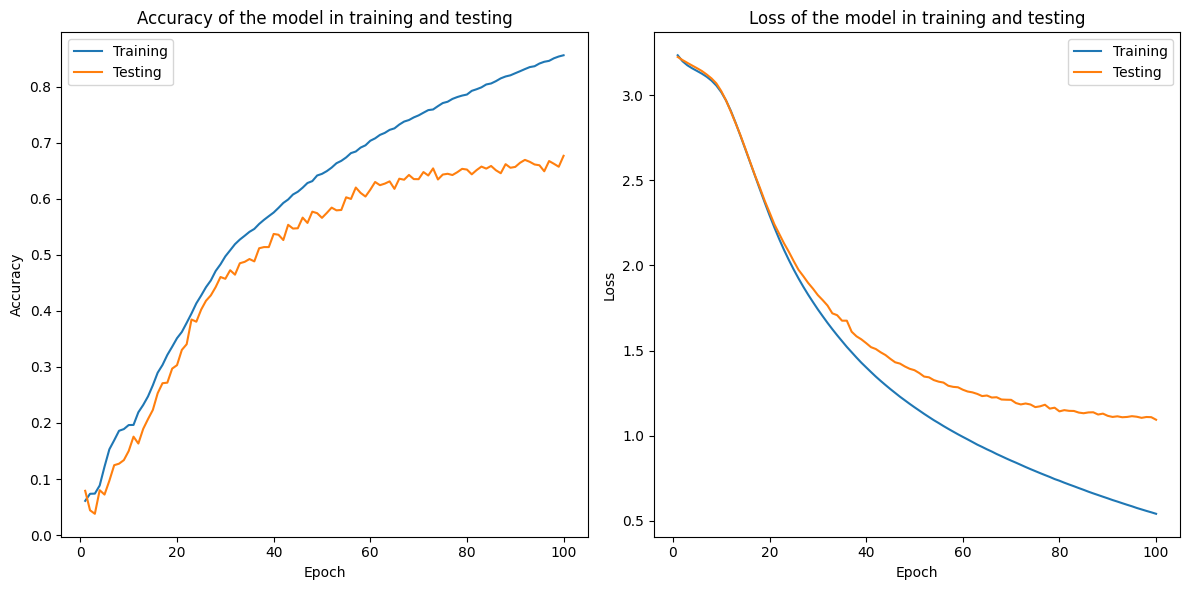

In [68]:
plot_performance(history)